# Various TE and T_ME models comparison

In this notebook, we first show the results of running a TE_coupled_AE for all patchseq cells used in the inh and exc patchseq papers. More specifically, we will run T_only and E_only autoencoders and then TE_coupled autoencoders, then we use the latent representations of each of these models to classify T_types. We expect to see that coupling E to T, will improve the T_type classification accuracy of E arm when compared to the baseline E_only autoencoder. We will show that, this result is obtained only if we implement augmentation for the T and E decoders in the TE_coupled_AE model. 

After that, we present the T_ME coupled autoencoder. The hypothesis in this 3 modality coupled AE is that, M data will enrich E data and if we couple ME autoencoder to T autoencoder, then latent representation of ME arm is better than baseline ME_alone_AE or TE_coupled_AE or T_M_E autoencoder. 

In [121]:
import os
import feather
import umap 
import umap.plot
import umap.aligned_umap
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import cplAE_MET.utils.utils as ut
import cplAE_MET.utils.umap_helpers as ut_umap
import cplAE_MET.models.classification_functions as clf
import cplAE_MET.utils.analysis_helpers as ana
from cplAE_MET.utils.dataset import  load_MET_dataset, MET_data_summary

# This is used to be able to run the notebook both remote and locally
Allen_dir = "/allen/programs/celltypes/workgroups/rnaseqanalysis/Fahimehb/git_workspace/cplAE_MET/data/"
remote_dir = "/Users/fahimehb/Documents/git-workspace/cplAE_MET/data/"

parent_dir = Allen_dir

In [122]:
MET_data = load_MET_dataset(parent_dir + "proc/MET_data_16Feb22.mat")
MET_data_summary(MET_data)

T shape (5468, 1252)
E shape (5468, 134)
M shape (5468, 120, 4, 4)
sd shape (5468,)

Paired samples, allowing for nans in some features
5322 cells paired in T and E
1454 cells paired in T and M
1399 cells paired in E and M

Paired samples, without nans in any feature (strict)
5322 cells paired in T and E
1454 cells paired in T and M
1399 cells paired in E and M


In [24]:
MET_data = load_MET_dataset(parent_dir + "proc/MET_data_30Mar22.mat")
MET_data_summary(MET_data)

T shape (6570, 1252)
E shape (6570, 132)
M shape (6570, 120, 4, 4)
sd shape (6570,)

Paired samples, allowing for nans in some features
5854 cells paired in T and E
1515 cells paired in T and M
1413 cells paired in E and M

Paired samples, without nans in any feature (strict)
5854 cells paired in T and E
1515 cells paired in T and M
1413 cells paired in E and M


# TE_autoencoder

We ran multiple TE_coupled_AE with varied directional coupling strength between T and E arms. First, this was done in the absense of the augment_decoders. Also the baseline T_only_AE and E_only_AE were implemented. For each of the runs, we used QDA classifier to compute the accuracy of T_type classification from the latent representations. 

In [25]:
TE_runs_path = parent_dir + "/results/triple_mode_version_0.0/"

TE_run_folders = [
    # models without augment_decoder implemented
    "min_var_loss_TE_aT_1.0_aE_1.0_lmd_TE_1.0_lmd_tune_TE_0.5", 
    "min_var_loss_TE_aT_10.0_aE_10.0_lmd_TE_1.0_lmd_tune_TE_0.5",
    "min_var_loss_TE_aT_2.0_aE_2.0_lmd_TE_1.0_lmd_tune_TE_0.5",
    "min_var_loss_TE_aT_5.0_aE_5.0_lmd_TE_1.0_lmd_tune_TE_0.5", 
    "min_var_loss_TE_aT_0.5_aE_0.5_lmd_TE_1.0_lmd_tune_TE_0.5", 
    "min_var_loss_TE_aT_100.0_aE_100.0_lmd_TE_1.0_lmd_tune_TE_0.5", 
    "min_var_loss_TE_aT_50.0_aE_50.0_lmd_TE_1.0_lmd_tune_TE_0.5", 
    "min_var_loss_TE_aT_1.0_aE_1.0_lmd_TE_0.0_lmd_tune_TE_0.0",
    # models with augment_decoder implemented
    "min_var_loss_TE_aT_1.0_aE_1.0_lmd_TE_1.0_lmd_tune_TE_0.75_aug_dec_1.0", 
    "min_var_loss_TE_aT_2.0_aE_2.0_lmd_TE_1.0_lmd_tune_TE_0.5_aug_dec_1.0",
    "min_var_loss_TE_aT_1.0_aE_1.0_lmd_TE_1.0_lmd_tune_TE_1.0_aug_dec_1.0",
    "min_var_loss_TE_aT_0.5_aE_0.5_lmd_TE_1.0_lmd_tune_TE_0.5_aug_dec_1.0",
    "min_var_loss_TE_aT_1.0_aE_1.0_lmd_TE_1.0_lmd_tune_TE_0.5_aug_dec_1.0"]

In [2]:
alldf = pd.DataFrame()
output = {}
for folder in TE_run_folders:
    files_path = TE_runs_path+folder + "/"
    files = os.listdir(files_path)
    out, df = ana.get_TE_pkl_keys(files_path, files)
    output.update(out)
    alldf = pd.concat([df, alldf],  ignore_index=True)
    

In [ ]:
# All the TE runs with and without aug_decs
alldf

,alphaT,alphaE,lambda_TE,lambda_tune_TE,aug_dec,latent_dim,fold,classification_acc_zt,classification_acc_ze,recon_loss_xt,recon_loss_xe
0,1.0,1.0,1.0,0.5,1.0,5,5,73.491773,43.789474,1.932613,0.065373
1,1.0,1.0,1.0,0.5,1.0,5,1,72.029250,41.894737,1.933841,0.074694
2,1.0,1.0,1.0,0.5,1.0,5,3,72.394881,42.105263,1.893291,0.060597
3,1.0,1.0,1.0,0.5,1.0,5,2,71.297989,43.789474,1.946871,0.066104
4,1.0,1.0,1.0,0.5,1.0,5,8,71.663620,42.526316,1.907636,0.063606
...,...,...,...,...,...,...,...,...,...,...,...
123,1.0,1.0,1.0,0.5,0.0,5,7,72.760512,38.105263,1.913934,0.055723
124,1.0,1.0,1.0,0.5,0.0,5,0,74.040219,31.157895,1.866193,0.056368
125,1.0,1.0,1.0,0.5,0.0,5,2,71.846435,29.263158,1.972910,0.043704
126,1.0,1.0,1.0,0.5,0.0,5,4,75.319927,30.947368,1.872821,0.060134


Below, the first row is the baseline and shows the classification acc for the T_only_AE and E_only_AE which are 76.6% and 35.22% correspondingly. The rest of the table shows the effect of changing alphaT and alphaE in the TE_coupled_AE model. As it is clear, only when we increase these values a lot, the model accuracy gets better than the baseline for both arms. Increasing the alphaT and alphaE while keeping lambda_TE constant, means encouraging the model to mainly focus on the T and E autoencoders and not caring much about the coupling. As this is contrary to what we want (to enrich the model by coupling), we decided to implement more augmentation to the model to see if we can improve the results. 

In [ ]:
# grouping tests without the aug_decs
alldf[alldf['aug_dec']!=1].groupby(["aug_dec", "lambda_TE", "alphaT", "alphaE"]).mean().drop(columns=["fold"])

lambda_tune_TE  latent_dim  \
aug_dec lambda_TE alphaT alphaE                               
0.0     0.0       1.0    1.0                0.0         5.0   
        1.0       0.5    0.5                0.5         5.0   
                  1.0    1.0                0.5         5.0   
                  2.0    2.0                0.5         5.0   
                  5.0    5.0                0.5         5.0   
                  10.0   10.0               0.5         5.0   
                  50.0   50.0               0.5         5.0   
                  100.0  100.0              0.5         5.0   

                                 classification_acc_zt  classification_acc_ze  \
aug_dec lambda_TE alphaT alphaE                                                 
0.0     0.0       1.0    1.0                 76.636197              35.221053   
        1.0       0.5    0.5                 73.308958              32.888889   
                  1.0    1.0                 73.455210              32.884211   
                  2.0    2.0                 74.186472              34.126316   
                  5.0    5.0                 74.954296              35.136842   
                  10.0   10.0                75.929311              35.415205   
                  50.0   50.0                76.819013              36.421053   
                  100.0  100.0               76.672761              36.842105   

                                 recon_loss_xt  recon_loss_xe  
aug_dec lambda_TE alphaT alphaE                                
0.0     0.0       1.0    1.0          1.925121       0.032674  
        1.0       0.5    0.5          1.867399       0.070778  
                  1.0    1.0          1.884191       0.063739  
                  2.0    2.0          1.913598       0.055476  
                  5.0    5.0          1.943060       0.049854  
                  10.0   10.0         1.990347       0.052797  
                  50.0   50.0         2.039525       0.040777  
                  100.0  100.0        2.040239       0.040637

Below, we present the results of the model in the presence of the augment_decoders. As it is suggested by the table, we could improve the results of the classification acc by implementing augmentation. especially, the E_arm classification acc is improved. Furthermore, we can improve the results by changing the alphaT and alphaE values as it is seen in the follwoing table.

In [ ]:
# grouping tests with the aug_decs and equal strength coupling between T and E
alldf[(alldf['aug_dec']==1) & (alldf['lambda_tune_TE']==0.5)].groupby(["aug_dec","lambda_TE", "alphaT", "alphaE"]).mean().drop(columns=["fold"])

lambda_tune_TE  latent_dim  \
aug_dec lambda_TE alphaT alphaE                               
1.0     1.0       0.5    0.5                0.5         5.0   
                  1.0    1.0                0.5         5.0   
                  2.0    2.0                0.5         5.0   

                                 classification_acc_zt  classification_acc_ze  \
aug_dec lambda_TE alphaT alphaE                                                 
1.0     1.0       0.5    0.5                 71.297989              40.084211   
                  1.0    1.0                 72.138940              43.115789   
                  2.0    2.0                 73.455210              46.210526   

                                 recon_loss_xt  recon_loss_xe  
aug_dec lambda_TE alphaT alphaE                                
1.0     1.0       0.5    0.5          1.917425       0.070653  
                  1.0    1.0          1.920738       0.065997  
                  2.0    2.0          1.928929       0.059113

On a side note, as table below is suggesting, when we move the TE_coupled_AE towards one-directional coupled_TE  for which T is affecting E representation but E is not affecting T the T-type classification acc is much higher. 

In [ ]:
# grouping tests with aug_decs and varried lambda_tune_TE
alldf[(alldf['alphaT']==1.0) & alldf['aug_dec']==1.0].groupby(["aug_dec","lambda_tune_TE"]).mean().drop(columns=["fold"])

alphaT  alphaE  lambda_TE  latent_dim  \
aug_dec lambda_tune_TE                                          
1.0     0.50               1.0     1.0        1.0         5.0   
        0.75               1.0     1.0        1.0         5.0   
        1.00               1.0     1.0        1.0         5.0   

                        classification_acc_zt  classification_acc_ze  \
aug_dec lambda_tune_TE                                                 
1.0     0.50                        72.138940              43.115789   
        0.75                        73.638026              46.526316   
        1.00                        76.855576              60.652632   

                        recon_loss_xt  recon_loss_xe  
aug_dec lambda_tune_TE                                
1.0     0.50                 1.920738       0.065997  
        0.75                 1.906377       0.077091  
        1.00                 1.887109       0.105252

Let's look at one of the coupled TE model with bidirectional coupling, alphaT=alphaE=2 and aug_decs=True. 

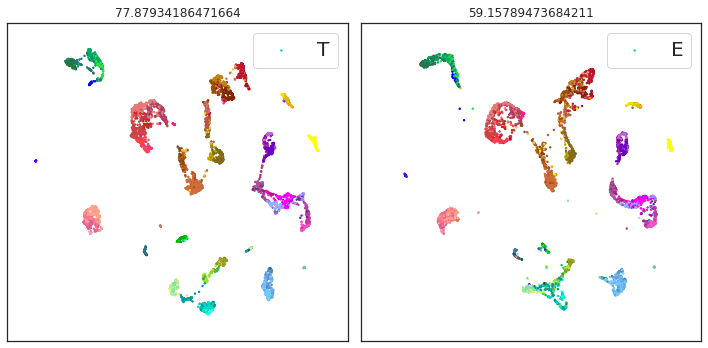

In [ ]:
results_path = parent_dir + "/results/triple_mode_version_0.0/min_var_loss_TE_aT_1.0_aE_1.0_lmd_TE_1.0_lmd_tune_TE_1.0_aug_dec_1.0/"
exit_summary = "exit_summary_min_var_loss_TE_aT_1-0_aE_1-0_lambda_TE_1-0_lambda_tune_TE_1-0_Enoise_0-05_aug_dec_1_ld_5_ne_20000_ri_0_fold_1.pkl"

TE = ut.loadpkl(results_path + exit_summary)
valid_E = TE['valid_E']
valid_T = TE['valid_T']
valid_TE = np.where(valid_E & valid_T, True, False)
valid_TE_E = valid_TE[valid_E]
valid_TE_T = valid_TE[valid_T]

# relation is between consecutive pair of data 
relation = dict(zip(np.where(valid_TE_T)[0] ,np.where(valid_TE_E)[0]))
embs = [TE['zt'], TE['ze']]

aligned_mapper = umap.AlignedUMAP().fit(embs, relations=[relation])

def axis_bounds(embedding):
    left, right = embedding.T[0].min(), embedding.T[0].max()
    bottom, top = embedding.T[1].min(), embedding.T[1].max()
    adj_h, adj_v = (right - left) * 0.1, (top - bottom) * 0.1
    return [left - adj_h, right + adj_h, bottom - adj_v, top + adj_v]

fig, axs = plt.subplots(1,2, figsize=(10, 5))
ax_bound = axis_bounds(np.vstack(aligned_mapper.embeddings_))
for i, ax in enumerate(axs.flatten()):
    current_target = [TE['cluster_color'][TE["valid_T"]], TE['cluster_color'][TE["valid_E"]]]
    current_label = ["T", "E"]
    current_title = [TE['classification_acc_zt'], TE['classification_acc_ze']]
    ax.scatter(*aligned_mapper.embeddings_[i].T, s=2, c=current_target[i], cmap="Spectral", label=current_label[i])
    ax.set_title(current_title[i])
    ax.axis(ax_bound)
    ax.set(xticks=[], yticks=[])
    ax.legend(prop={'size': 20})
plt.tight_layout()


# Various T_ME coupled AE

In the following, we add the M data to T and E and try to build a model in which M data is improving our previous TE model. We had many questions to be answered:
 - Does T-ME_coupled_AE performs better than TE_coupled_AE in classification of T types? the hypothesis is that, M data should enrich E data and then coupling ME with T should gives us a better model than TE.
 - Does T-M-E_coupled_AE performs worse than T_ME_coupled_AE? the hypothesis is that, E and M data are not very high resolution, therefore combining M and E should gives us a better model.
 - Does T-ME_coupled_AE perfroms better than ME and T alone?
 - Does adding M and E autoencoder improve the results in ME arm?

In [5]:
T_ME_runs_path = "/allen/programs/celltypes/workgroups/rnaseqanalysis/Fahimehb/git_workspace/cplAE_MET/data/results/triple_mode_version_0.0/"
T_ME_runs_folders = [
    # Without aug_dec
    "T_ME_aT_0.0_aE_1.0_aM_1.0_aME_1.0_lmd_ME_T_0.0_lmd_ME_M_1.0_lmd_ME_E_1.0_lmd_tune_ME_T_0.0",
    "T_ME_aT_0.5_aE_0.5_aM_0.5_aME_0.5_lmd_ME_T_1.0_lmd_ME_M_1.0_lmd_ME_E_1.0_lmd_tune_ME_T_0.5",
    "T_ME_aT_1.0_aE_0.0_aM_0.0_aME_1.0_lmd_ME_T_0.0_lmd_ME_M_0.0_lmd_ME_E_0.0_lmd_tune_ME_T_0.0", 
    "T_ME_aT_1.0_aE_0.0_aM_0.0_aME_1.0_lmd_ME_T_1.0_lmd_ME_M_0.0_lmd_ME_E_0.0_lmd_tune_ME_T_0.5",
    "T_ME_aT_1.0_aE_0.0_aM_0.0_aME_1.0_lmd_ME_T_1.0_lmd_ME_M_0.0_lmd_ME_E_0.0_lmd_tune_ME_T_0.75",
    "T_ME_aT_1.0_aE_0.0_aM_0.0_aME_1.0_lmd_ME_T_1.0_lmd_ME_M_0.0_lmd_ME_E_0.0_lmd_tune_ME_T_0.9",
    "T_ME_aT_1.0_aE_0.0_aM_0.0_aME_1.0_lmd_ME_T_1.0_lmd_ME_M_0.0_lmd_ME_E_0.0_lmd_tune_ME_T_1.0",
    "T_ME_aT_1.0_aE_1.0_aM_1.0_aME_1.0_lmd_ME_T_1.0_lmd_ME_M_1.0_lmd_ME_E_1.0_lmd_tune_ME_T_0.5",
    "T_ME_aT_1.0_aE_1.0_aM_1.0_aME_1.0_lmd_ME_T_1.0_lmd_ME_M_1.0_lmd_ME_E_1.0_lmd_tune_ME_T_0.75",
    "T_ME_aT_1.0_aE_1.0_aM_1.0_aME_1.0_lmd_ME_T_1.0_lmd_ME_M_1.0_lmd_ME_E_1.0_lmd_tune_ME_T_0.9",
    "T_ME_aT_1.0_aE_1.0_aM_1.0_aME_1.0_lmd_ME_T_1.0_lmd_ME_M_1.0_lmd_ME_E_1.0_lmd_tune_ME_T_1.0",
    "T_ME_aT_2.0_aE_2.0_aM_2.0_aME_2.0_lmd_ME_T_1.0_lmd_ME_M_1.0_lmd_ME_E_1.0_lmd_tune_ME_T_0.5",
    "T_ME_aT_5.0_aE_5.0_aM_5.0_aME_5.0_lmd_ME_T_1.0_lmd_ME_M_1.0_lmd_ME_E_1.0_lmd_tune_ME_T_0.5",
    # With aug_dec
    "T_ME_aT_0.5_aE_0.5_aM_0.5_aME_0.5_lmd_ME_T_1.0_lmd_ME_M_1.0_lmd_ME_E_1.0_lmd_tune_ME_T_0.5_aug_dec_1",
    "T_ME_aT_1.0_aE_1.0_aM_1.0_aME_1.0_lmd_ME_T_1.0_lmd_ME_M_1.0_lmd_ME_E_1.0_lmd_tune_ME_T_0.5_aug_dec_1",
    "T_ME_aT_2.0_aE_2.0_aM_2.0_aME_2.0_lmd_ME_T_1.0_lmd_ME_M_1.0_lmd_ME_E_1.0_lmd_tune_ME_T_0.5_aug_dec_1",
    "T_ME_aT_5.0_aE_5.0_aM_5.0_aME_5.0_lmd_ME_T_1.0_lmd_ME_M_1.0_lmd_ME_E_1.0_lmd_tune_ME_T_0.5_aug_dec_1",
     # Added more cells to the model, some have only M
    "more_cells_T_ME_aT_5.0_aE_5.0_aM_5.0_asd_1.0_aME_5.0_lmd_ME_T_1.0_lmd_ME_M_1.0_lmd_ME_E_1.0_lmd_tune_ME_T_0.75_aug_dec_1"
    ]

In [6]:
# This might take several minutes
alldf = pd.DataFrame()
for folder in T_ME_runs_folders:
    files_path = T_ME_runs_path + folder + "/"
    files = os.listdir(files_path)
    out, df = ana.get_T_ME_pkl_keys(files_path, files)
    alldf = pd.concat([df, alldf],  ignore_index=True)

In [7]:
alldf['aug_dec']= alldf['aug_dec'].fillna(0)

In [8]:
alldf

,aT,aE,aM,asd,aME,lambda_ME_T,lambda_ME_M,lambda_ME_E,lambda_tune_ME_T,latent_dim,aug_dec,fold,classification_acc_zt,classification_acc_ze,classification_acc_zm,classification_acc_zme
0,5.0,5.0,5.0,1.0,5.0,1.0,1.0,1.0,0.75,5,1.0,7,76.000000,37.937743,15.753425,63.333333
1,5.0,5.0,5.0,1.0,5.0,1.0,1.0,1.0,0.75,5,1.0,0,75.538462,32.295720,22.602740,63.333333
2,5.0,5.0,5.0,1.0,5.0,1.0,1.0,1.0,0.75,5,1.0,6,75.846154,35.214008,36.986301,69.166667
3,5.0,5.0,5.0,1.0,5.0,1.0,1.0,1.0,0.75,5,1.0,3,75.076923,33.657588,37.671233,66.666667
4,5.0,5.0,5.0,1.0,5.0,1.0,1.0,1.0,0.75,5,1.0,6,75.692308,33.852140,41.780822,58.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.00,5,0.0,3,19.195612,26.105263,35.507246,43.333333
171,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.00,5,0.0,9,18.098720,28.421053,26.086957,49.166667
172,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.00,5,0.0,2,18.098720,28.421053,34.782609,50.000000
173,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.00,5,0.0,4,15.722121,29.263158,37.681159,50.000000


First of all, we would like to know what is the classification acc for the ME_only_AE and T_only_AE. for T data the accuracy is 78% and for ME together it is 47%. Note that E_only_AE had an accuracy of almost 35%. So this is proving that adding M data to E, has already boost the model. 

In [9]:
# baseline ME and T UNcoupled autoencoders 
alldf[(alldf['lambda_ME_T']==0.0) & (alldf['aT']==1.0)][["classification_acc_zt", "classification_acc_zme", "classification_acc_ze", "classification_acc_zm"]].mean()

classification_acc_zt     78.043876
classification_acc_zme    47.333333
classification_acc_ze     24.252632
classification_acc_zm     31.521739
dtype: float64

One other thing that I was curious to try was an ME_AE in which we have M_AE and E_AE coupled to it one directionally. Meaning that E and M can't affect zme and it is only zme which is affecting ze and zm. Our results suggest that this model, improved with respect to the previous model in which we did not have a coupling between ME and E as well as between ME and M. 

In [10]:
alldf[(alldf['lambda_ME_T']==0.0) & (alldf['aT']!=1.0)][["classification_acc_zt", "classification_acc_zme", "classification_acc_ze", "classification_acc_zm"]].mean()

classification_acc_zt     17.123705
classification_acc_zme    48.333333
classification_acc_ze     28.257310
classification_acc_zm     33.655395
dtype: float64

Now, lets couple ME and T. there is no E or M autoencoders and no connection between ME and E or ME and M representations. The only thing which can be kind of a "coupling" is that ME are shares decoders with M and E arms. This means, we are expecting to see a better M and E representations just because the decoders are having information from ME arm. but when we look at the representations, the orientations of M and E are not going to be aligned as ME and T.

Below, we present the results of the ME_T coupling, also we have played with the directionality of the coupling. 

As it is clear from the table, the results in all the arms are better than the uncoupled version presented above.

In [11]:
alldf[(alldf['lambda_ME_T']==1.0) & (alldf['lambda_ME_M']==0.0)].groupby(['lambda_tune_ME_T']).mean().drop(columns=['fold'])

,aT,aE,aM,asd,aME,lambda_ME_T,lambda_ME_M,lambda_ME_E,latent_dim,aug_dec,classification_acc_zt,classification_acc_ze,classification_acc_zm,classification_acc_zme
lambda_tune_ME_T,,,,,,,,,,,,,,
0.50,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,5.0,0.0,74.460695,29.957895,33.623188,52.666667
0.75,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,5.0,0.0,75.722121,31.726316,33.188406,57.000000
0.90,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,5.0,0.0,77.074954,32.610526,34.782609,63.583333
1.00,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,5.0,0.0,77.202925,32.842105,28.768116,71.166667


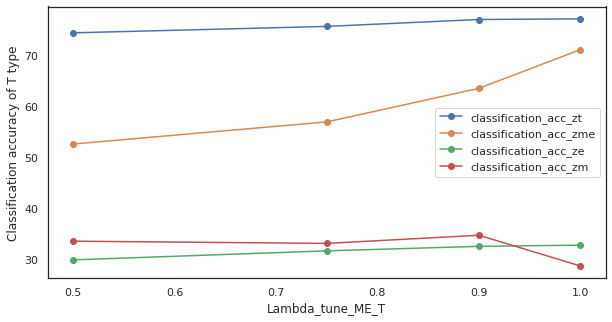

In [12]:
subdf = alldf[(alldf['lambda_ME_T']==1.0) & (alldf['lambda_ME_M']==0.0)].groupby(['lambda_tune_ME_T']).mean().drop(columns=['fold']).reset_index()

fig = plt.figure(figsize=(10,5))

current_label = [
    "classification_acc_zt", "classification_acc_zme", 
    "classification_acc_ze", "classification_acc_zm"]

for i, var in enumerate([
    subdf['classification_acc_zt'], subdf['classification_acc_zme'], 
    subdf['classification_acc_ze'], subdf['classification_acc_zm']]):

    plt.plot(subdf['lambda_tune_ME_T'], var, "o-", label=current_label[i])

plt.xlabel("Lambda_tune_ME_T")
plt.ylabel("Classification accuracy of T type")

plt.legend()

As we are interested, in bidirectional coupling between ME and T autoencoders, we set the lambda_tune_ME_T to 0.5 and changed alphaE, alphaT, alphaM and alphaME. Moreover, we implemented the augmentation for decoders and table below summarized the results. 

In [13]:
alldf[(alldf['lambda_ME_T']==1.0) & (alldf['lambda_ME_M']==1.0) & (alldf['lambda_tune_ME_T']==0.5) & (alldf['asd']==alldf['aM'])].groupby(["aug_dec", "aT"]).mean().drop(columns=["fold"])

aE   aM  asd  aME  lambda_ME_T  lambda_ME_M  lambda_ME_E  \
aug_dec aT                                                               
0.0     0.5  0.5  0.5  0.5  0.5          1.0          1.0          1.0   
        1.0  1.0  1.0  1.0  1.0          1.0          1.0          1.0   
        2.0  2.0  2.0  2.0  2.0          1.0          1.0          1.0   
        5.0  5.0  5.0  5.0  5.0          1.0          1.0          1.0   
1.0     0.5  0.5  0.5  0.5  0.5          1.0          1.0          1.0   
        1.0  1.0  1.0  1.0  1.0          1.0          1.0          1.0   
        2.0  2.0  2.0  2.0  2.0          1.0          1.0          1.0   
        5.0  5.0  5.0  5.0  5.0          1.0          1.0          1.0   

             lambda_tune_ME_T  latent_dim  classification_acc_zt  \
aug_dec aT                                                         
0.0     0.5               0.5         5.0              73.528336   
        1.0               0.5         5.0              74.748629   
        2.0               0.5         5.0              75.612431   
        5.0               0.5         5.0              76.764168   
1.0     0.5               0.5         5.0              70.950640   
        1.0               0.5         5.0              73.016453   
        2.0               0.5         5.0              74.789762   
        5.0               0.5         5.0              74.606947   

             classification_acc_ze  classification_acc_zm  \
aug_dec aT                                                  
0.0     0.5              25.515789              33.985507   
        1.0              24.763158              31.974638   
        2.0              28.168421              31.231884   
        5.0              29.873684              32.898551   
1.0     0.5              26.905263              33.188406   
        1.0              30.357895              34.057971   
        2.0              32.589474              33.115942   
        5.0              34.652632              35.144928   

             classification_acc_zme  
aug_dec aT                           
0.0     0.5               51.750000  
        1.0               53.020833  
        2.0               54.583333  
        5.0               53.666667  
1.0     0.5               62.083333  
        1.0               63.916667  
        2.0               65.583333  
        5.0               66.500000

In [14]:
alldf[(alldf['lambda_ME_T']==1.0) & (alldf['lambda_ME_M']==1.0) & (alldf['asd']!=alldf['aM']) & (alldf['latent_dim']==5)].groupby(['aug_dec', 'lambda_tune_ME_T']).mean().drop(columns=['fold'])

,,aT,aE,aM,asd,aME,lambda_ME_T,lambda_ME_M,lambda_ME_E,latent_dim,classification_acc_zt,classification_acc_ze,classification_acc_zm,classification_acc_zme
aug_dec,lambda_tune_ME_T,,,,,,,,,,,,,
1.0,0.75,5.0,5.0,5.0,1.0,5.0,1.0,1.0,1.0,5.0,76.064103,33.576524,30.650685,64.444444


Text(0.5, 0, 'AlphaE / AlphaT / AlphaM / AlphaME')

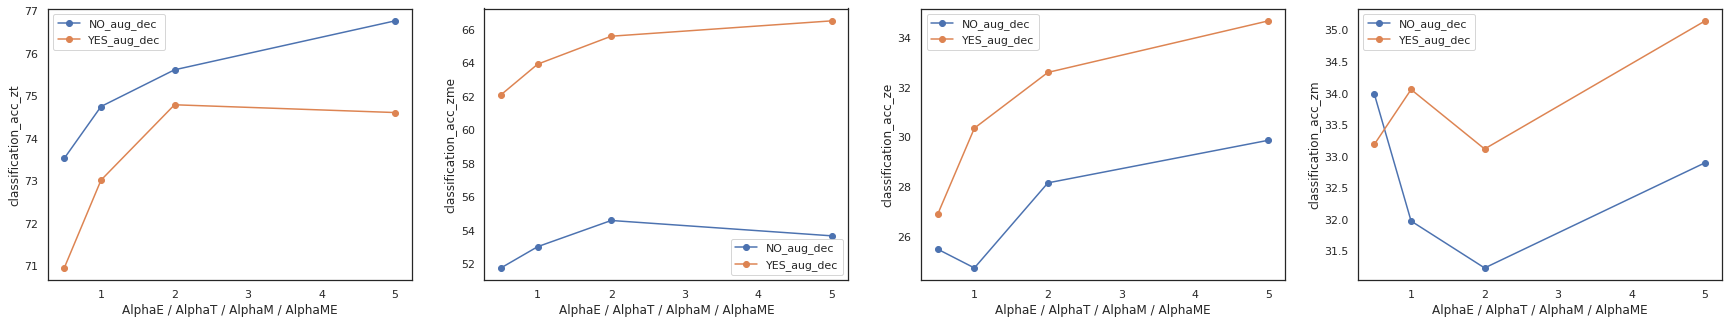

In [16]:
subdf = alldf[(alldf['lambda_ME_T']==1.0) & (alldf['lambda_ME_M']==1.0) & (alldf['lambda_tune_ME_T']==0.5)].groupby(["aug_dec", "aT"]).mean().drop(columns=["fold"]).reset_index()
subsubdf1 = subdf[subdf["aug_dec"]==0.0]
subsubdf2 = subdf[subdf["aug_dec"]==1.0]

fig, axs = plt.subplots(1,4, figsize=(30, 5))
for i, ax in enumerate(axs.flatten()):
    for sdf, marker, aug in zip([subsubdf1, subsubdf2], ["o-", "x-"], ["NO_aug_dec", "YES_aug_dec"]):
        var = [sdf['classification_acc_zt'], sdf['classification_acc_zme'], sdf['classification_acc_ze'], sdf['classification_acc_zm']]
        current_label = ["classification_acc_zt", "classification_acc_zme", "classification_acc_ze", "classification_acc_zm"]
        ax.plot(sdf['aT'], var[i], "o-", label=aug)
        ax.legend()
        ax.set_xlabel("AlphaE / AlphaT / AlphaM / AlphaME")
        ax.set_ylabel(current_label[i])

plt.xlabel("AlphaE / AlphaT / AlphaM / AlphaME")

Classification accuracy of zt drops by a bit when augmenting decoders (top figure left). Classification acc os zme, ze and zm has improved. more importantly this value improved a lot for zme. Also increasing alphaE, T, M and ME increased the classification accuary of all the above tests.

In [98]:
def plot_aligned_umap(model_output):
    
    embs = ut_umap.get_T_ME_model_emb_list(model_output)

    relations = ut_umap.get_T_ME_model_umap_relation_list(model_output)

    color_list = ut_umap.get_T_ME_model_umap_colors_list(model_output)

    title_list = [model_output['classification_acc_zt'],
     model_output['classification_acc_ze'], 
     model_output['classification_acc_zme'],
      model_output['classification_acc_zm']]

    label_list = ["T", "E", "ME", "M"]

    ut_umap.plot_aligned_umap_T_ME(embs, relations, color_list, title_list, label_list)

    return

def plot_xsd_recon_for_Mval_cells(model_output):
    """
    Args:
        model_output: output of the T_ME model which has masks and recons 
    """
    # index of M cells from the total cells
    M_cells_ind_tot = np.where(model_output['M_tot'])[0]
    # index of validation cells from the total cells
    val_cells_ind_tot = model_output['val']
    # index of M validation cells from the total cells
    M_val_cells_ind_tot = np.array([i for i in M_cells_ind_tot if i in val_cells_ind_tot])
    # index of M validation cells from the M cells
    M_val_cells_ind_M = np.searchsorted(M_cells_ind_tot, M_val_cells_ind_tot)

    plt.figure(figsize=(20,5))
    plt.scatter(range(len(model_output['Xsd'][M_val_cells_ind_tot])), model_output['Xsd'][M_val_cells_ind_tot], label="Xsd")
    plt.scatter(range(len(model_output['Xrsd'][M_val_cells_ind_M])), model_output['Xrsd'][M_val_cells_ind_M], label="Xrsd")
    plt.legend()
    plt.xlabel("validation cells")
    plt.ylabel("soma depth")
    plt.title("Reconstructing soma depth")
    plt.show()


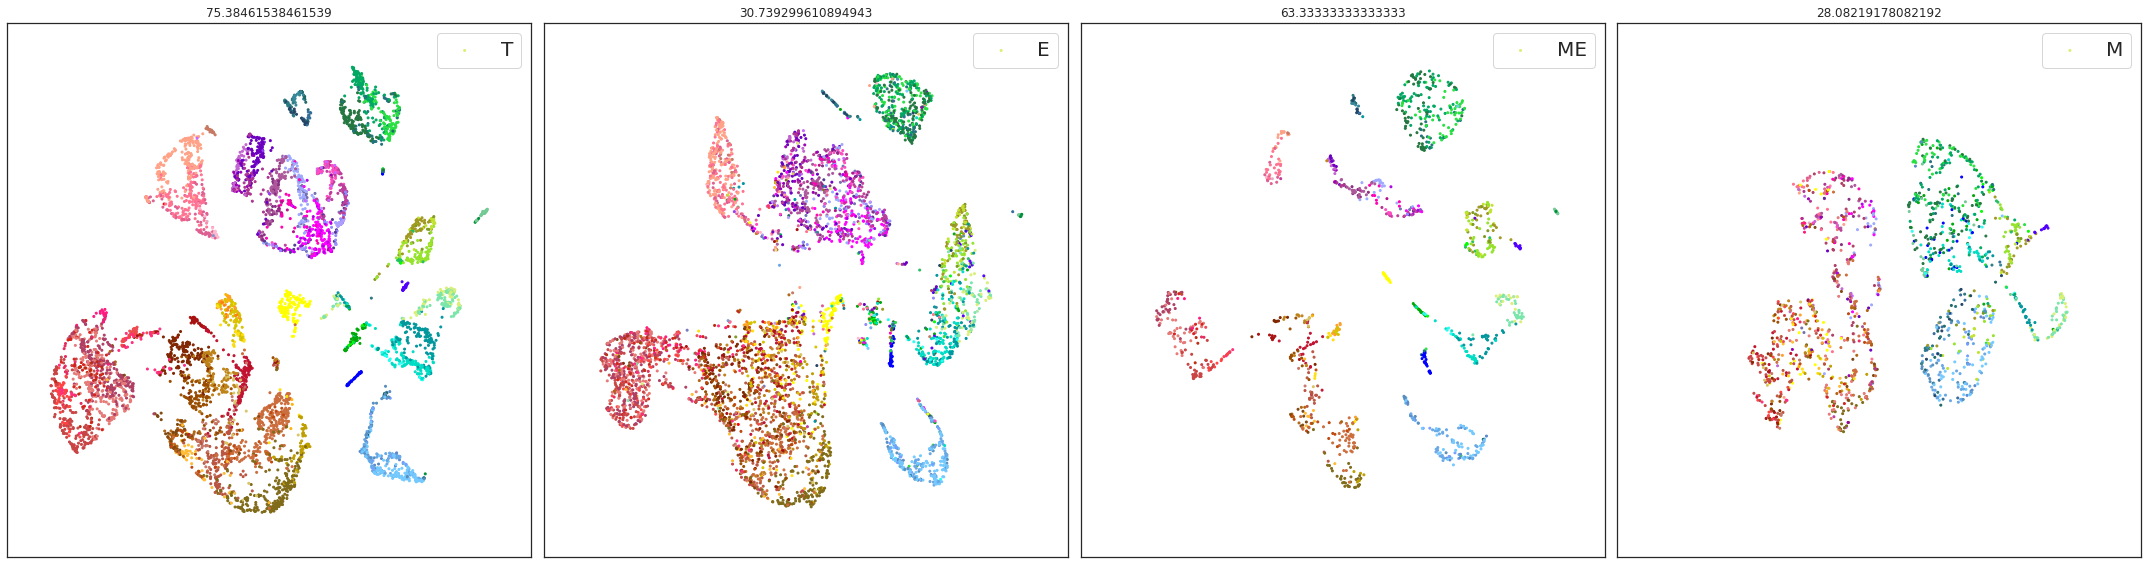

In [108]:
results_path = "/allen/programs/celltypes/workgroups/rnaseqanalysis/Fahimehb/git_workspace/cplAE_MET/data/results/triple_mode_version_0.0/more_cells_T_ME_aT_5.0_aE_5.0_aM_5.0_asd_1.0_aME_5.0_lmd_ME_T_1.0_lmd_ME_M_1.0_lmd_ME_E_1.0_lmd_tune_ME_T_0.75_aug_dec_1/"
exit_summary = "exit_summary_more_cells_T_ME_aT_5-0_aM_5-0_asd_1-0_aE_5-0_aME_5-0_lambda_ME_T_1-0_lambda_tune_ME_T_0-75_lambda_ME_M_1-0_lambda_ME_E_1-0_aug_dec_1_Enoise_0-05_Mnoise_0-0_scale_0-3_ld_5_ne_50000_ri_0_fold_2.pkl"
T_ME = ut.loadpkl(results_path + exit_summary)

plot_aligned_umap(T_ME)

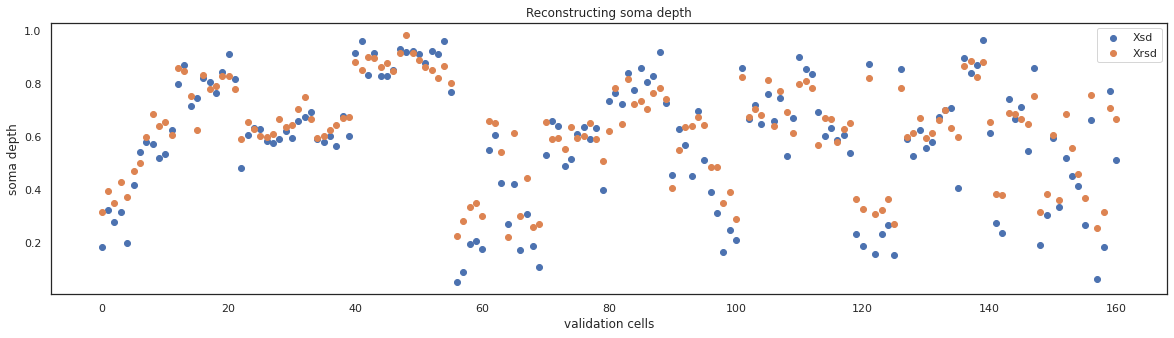

In [111]:
plot_xsd_recon_for_Mval_cells(T_ME)

In [171]:
anno = feather.read_dataframe("/allen/programs/celltypes/workgroups/rnaseqanalysis/Fahimehb/git_workspace/cplAE_MET/data/proc/anno.feather")

ref = anno[anno.spec_id_label.isin(model_output['specimen_id'].astype(str))][["Tree_first_cl_label", "subclass_label", "broad_class_label"]].rename(columns={
    "Tree_first_cl_label": "cluster_label", 
    "broad_class_label": "class_label"}).drop_duplicates()

ref['cluster_label'] = ref['cluster_label'].apply(lambda x: x.replace(" ", ""))
ref

,cluster_label,subclass_label,class_label
1,L2/3ITVISpRrad,L2/3 IT,Glutamatergic
101,L2/3ITVISpAdamts2,L2/3 IT,Glutamatergic
110,L2/3ITVISpAgmat,L2/3 IT,Glutamatergic
237,L4ITVISpRspo1,L4,Glutamatergic
430,L5ITVISpHsd11b1Endou,L5 IT,Glutamatergic
...,...,...,...
5860,PvalbVipr2,Pvalb,GABAergic
5910,Meis2Adamts19,Meis2,GABAergic
6002,L6ITVISpCol23a1Adamts2,L6 IT,Glutamatergic
7363,L6CTNxph2Sla,L6 CT,Glutamatergic


In [191]:
model_output = T_ME
# Run classification on the M latent space
_, _, labels, cf = clf.run_QDA(model_output['zm'][model_output['MT_M']], model_output['cluster_label'][model_output['MT_tot']], 0.1, 7)
# use the classifier to predict the type of the M_only cells
predictions = cf.predict(model_output['zm'][~model_output['MT_M']])
ids = model_output['specimen_id'][model_output['M_tot']][~model_output['MT_M']].astype(str)
predicted_labels = [labels[i] for i in predictions]
predictions = pd.DataFrame({'specimen_id': ids, "cluster_label": predicted_labels})
predictions = predictions.merge(ref, on="cluster_label").rename(columns={"cluster_label": "predicted_cluster_label", "subclass_label": "predicted_subclass_label", "class_label": "predicted_class_label"})

In [192]:
M_only_cells = [str(i) for i in T_ME['specimen_id'][T_ME['M_tot']][~T_ME['MT_M']]]
M_only_anno = anno[anno.spec_id_label.isin(M_only_cells)][["spec_id_label", "Tree_first_cl_label",'subclass_label', "broad_class_label"]].rename(columns={
    "spec_id_label": "specimen_id", 
    "Tree_first_cl_label": "cluster_label", 
    "broad_class_label": "class_label"})

M_only_anno['cluster_label'] = M_only_anno['cluster_label'].apply(lambda x: x.replace(" ", ""))

In [194]:
result = M_only_anno.merge(predictions, on="specimen_id")

In [199]:
print((result[result['cluster_label'] == result['predicted_cluster_label']].shape[0] / result.shape[0]) * 100)
print((result[result['subclass_label'] == result['predicted_subclass_label']].shape[0] / result.shape[0]) * 100)
print((result[result['class_label'] == result['predicted_class_label']].shape[0] / result.shape[0]) * 100)

23.333333333333332
63.33333333333333
100.0


317


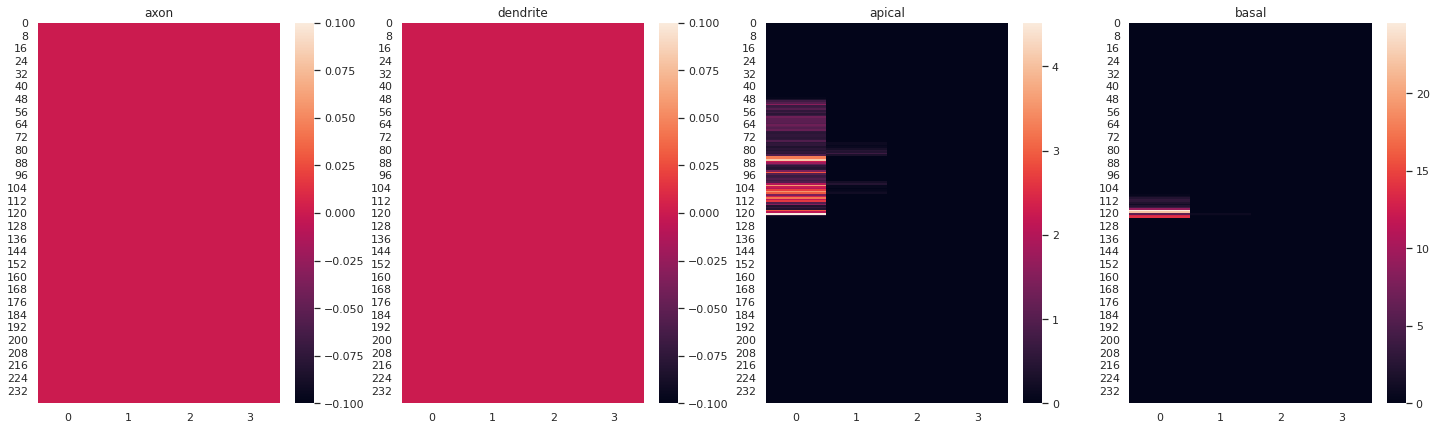

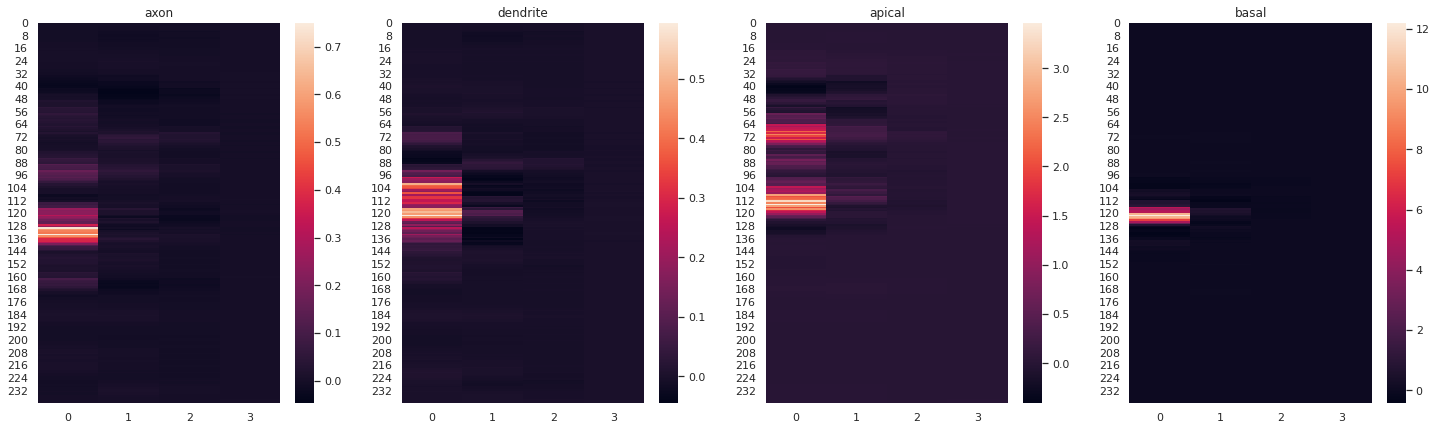

In [126]:
import seaborn as sns
out = T_ME
valid_ME = T_ME['ME_tot']
cell = np.random.randint(0,sum(valid_ME),1)[0]
print(cell)
fig, ax = plt.subplots(1,4, figsize=(25,7))
sns.heatmap(np.nan_to_num(out['XM'].squeeze())[valid_ME][cell,:,:,0], ax=ax[0], cbar=True) 
sns.heatmap(np.nan_to_num(out['XM'].squeeze())[valid_ME][cell,:,:,1], ax=ax[1], cbar=True)
sns.heatmap(np.nan_to_num(out['XM'].squeeze())[valid_ME][cell,:,:,2], ax=ax[2], cbar=True)
sns.heatmap(np.nan_to_num(out['XM'].squeeze())[valid_ME][cell,:,:,3], ax=ax[3], cbar=True)
ax[0].set_title("axon")
ax[1].set_title("dendrite")
ax[2].set_title("apical")
ax[3].set_title("basal")
plt.show()


fig, ax = plt.subplots(1,4, figsize=(25,7))
sns.heatmap(np.nan_to_num(out['XrM'].squeeze())[cell,:,:,0], ax=ax[0], cbar=True) 
sns.heatmap(np.nan_to_num(out['XrM'].squeeze())[cell,:,:,1], ax=ax[1], cbar=True)
sns.heatmap(np.nan_to_num(out['XrM'].squeeze())[cell,:,:,2], ax=ax[2], cbar=True)
sns.heatmap(np.nan_to_num(out['XrM'].squeeze())[cell,:,:,3], ax=ax[3], cbar=True)
ax[0].set_title("axon")
ax[1].set_title("dendrite")
ax[2].set_title("apical")
ax[3].set_title("basal")
plt.show()